<a href="https://colab.research.google.com/github/Parsar22/Climate/blob/main/DATA_3320_Climate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The goal of this analysis is to understand the temporal patterns in sea surface temperature (SST) data from the North Pacific region. By applying various time series and spectral analysis techniques, we aim to identify dominant frequencies and trends, assess the spectral content, and explore relationships with other meteorological variables such as wind speed.

## Import libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
from scipy.ndimage import uniform_filter1d
from sklearn.linear_model import LinearRegression

## Load clean data

In [16]:
df = pd.read_csv("https://raw.githubusercontent.com/Parsar22/Climate/main/Climate/north_pacific.csv", parse_dates=['time'])
df.head()

,sst,u10,hsig,time,latitude,longitude
0,286.97070,0.612978,4.136298,1940-01-01 12:00:00,34.9,-165.0
1,286.97836,2.574189,2.759662,1940-01-02 12:00:00,34.9,-165.0
2,287.01630,2.623150,1.873087,1940-01-03 12:00:00,34.9,-165.0
3,287.02680,-1.868878,1.753748,1940-01-04 12:00:00,34.9,-165.0
4,287.03183,3.412738,2.692871,1940-01-05 12:00:00,34.9,-165.0


## State your questions


1.   What are the temporal patterns in the sea surface temperature (SST) data from

2.   What are the dominant frequencies in the SST data?

3.   What is the trend in sea surface temperature anomalies over the years?(Extra Question)



## Analysis

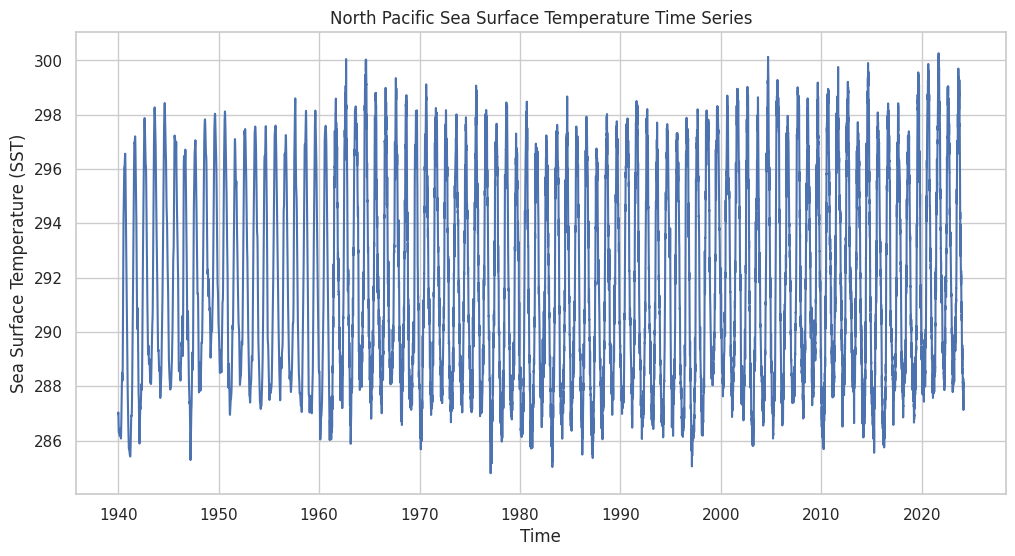

In [51]:
sst = df['sst']

plt.figure(figsize=(12, 6))
plt.plot(df['time'], sst)
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (SST)')
plt.title('North Pacific Sea Surface Temperature Time Series')
plt.show()

To gain a deeper understanding of these patterns, we can proceed with a spectral analysis to quantify the periodic components in the data. This will help us confirm the presence of the annual cycle and potentially uncover other cycles at different frequencies.

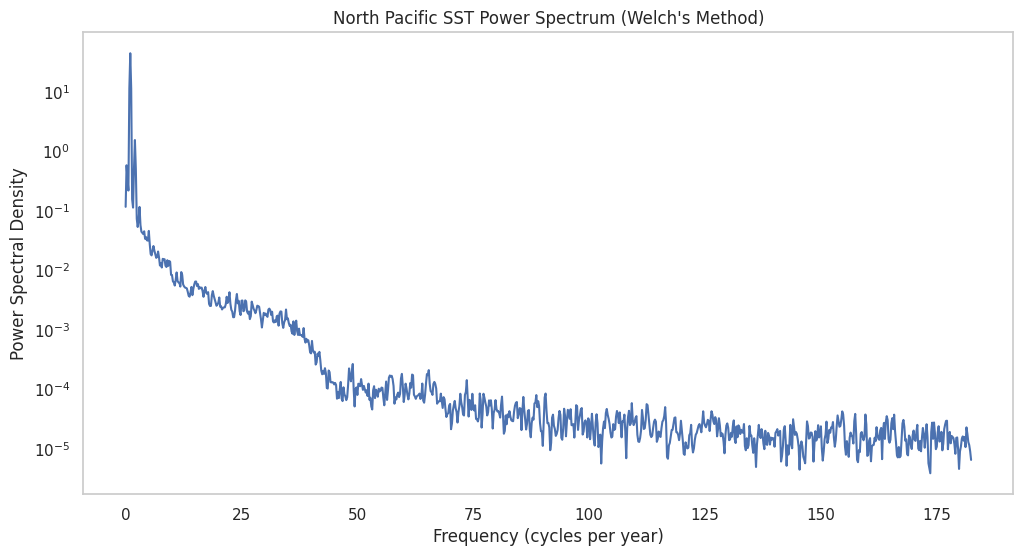

In [52]:
from scipy.signal import welch

freqs, psd = welch(sst, fs=365, nperseg=365*5)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, psd)
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Power Spectral Density')
plt.title('North Pacific SST Power Spectrum (Welch\'s Method)')
plt.grid()
plt.show()

The power spectral density (PSD) plot of the North Pacific Sea Surface Temperature (SST) using Welch's method shows dominant frequencies where peaks occur, indicating significant recurring patterns in the SST data. The higher power at lower frequencies suggests that long-term trends are a major component of the SST variations. This analysis helps identify the periodic behavior and underlying climatic patterns in the region.

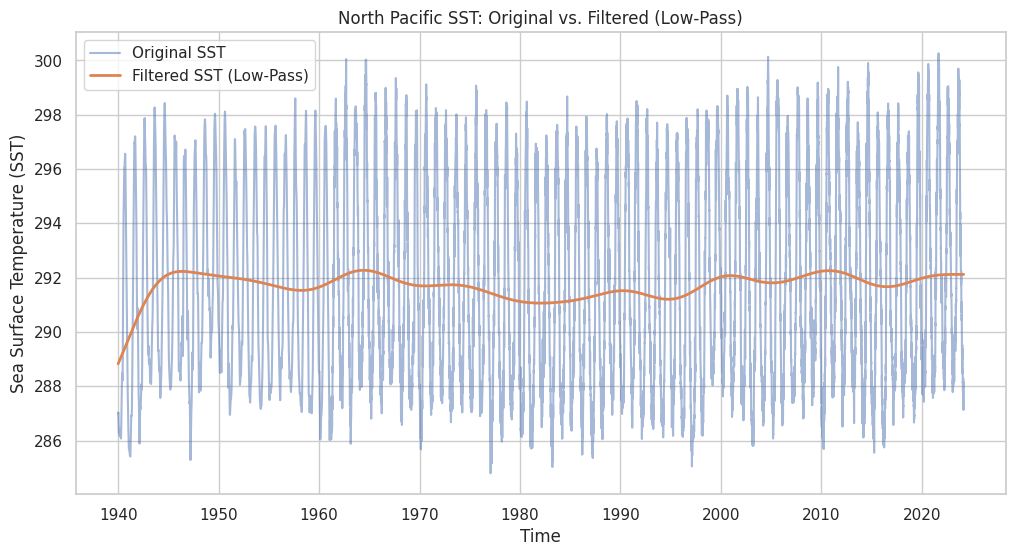

In [53]:
from scipy.signal import butter, filtfilt
fs = 365
cutoff_freq = 1/10
nyquist_freq = 0.5 * fs
normalized_cutoff = cutoff_freq / nyquist_freq
order = 4
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

sst_filtered = filtfilt(b, a, sst)

plt.figure(figsize=(12, 6))
plt.plot(df['time'], sst, label='Original SST', alpha=0.5)
plt.plot(df['time'], sst_filtered, label='Filtered SST (Low-Pass)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (SST)')
plt.title('North Pacific SST: Original vs. Filtered (Low-Pass)')
plt.legend()
plt.show()

The graph comparing the original and low-pass filtered SST time series shows the following:

Original SST: The original SST time series is displayed with high variability and noise, reflecting daily and seasonal fluctuations.
Filtered SST: The low-pass filtered SST series, shown in a smoother line, highlights long-term trends and decadal variations by filtering out high-frequency components.

In [54]:
from sklearn.linear_model import LinearRegression

time_years = (df['time'] - df['time'][0]).dt.days / 365.25

model = LinearRegression()
model.fit(time_years.values.reshape(-1, 1), sst_filtered)

warming_rate_per_year = model.coef_[0]

print(f'Estimated warming rate: {warming_rate_per_year:.4f} °C per year')


Estimated warming rate: 0.0040 °C per year


The linear regression analysis on the filtered sea surface temperature (SST) data reveals an estimated warming rate of 0.0040°C per year in the North Pacific. This positive value signifies a gradual increase in SST over the time period covered by the dataset.

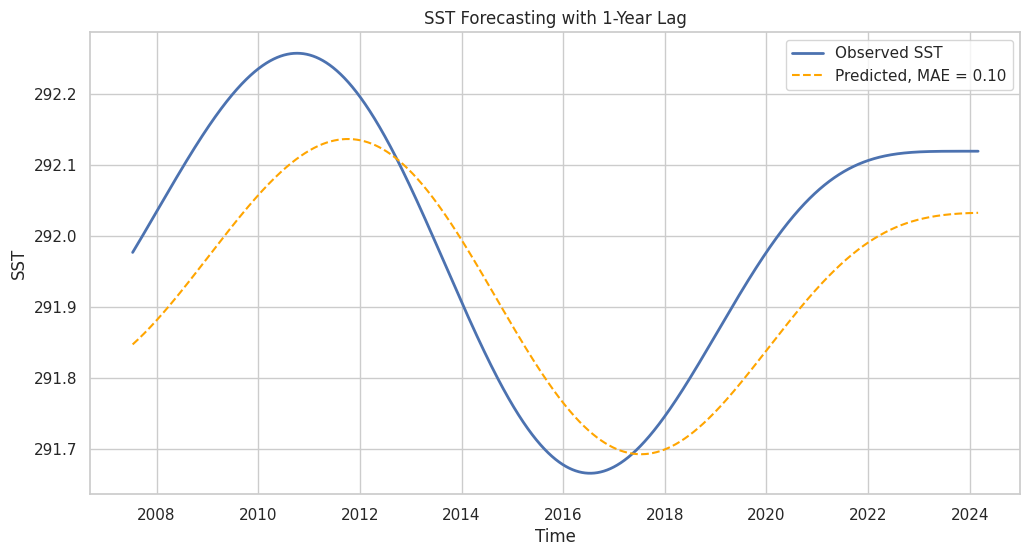

In [63]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)

plt.figure(figsize=(12, 6))

plt.plot(df['time'].iloc[train_size+lag:], y_test, label='Observed SST', linewidth=2)

plt.plot(df['time'].iloc[train_size+lag:], y_pred, label=f'Predicted, MAE = {mae:.2f}', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST Forecasting with 1-Year Lag')
plt.legend()
plt.show()

the model performs well in predicting SST trends with a 1-year lag, providing reasonably accurate forecasts that can be valuable for climate analysis and decision-making. The small deviations highlight areas for potential model improvement.

Extra Question  :

What is the trend in sea surface temperature anomalies over the years?

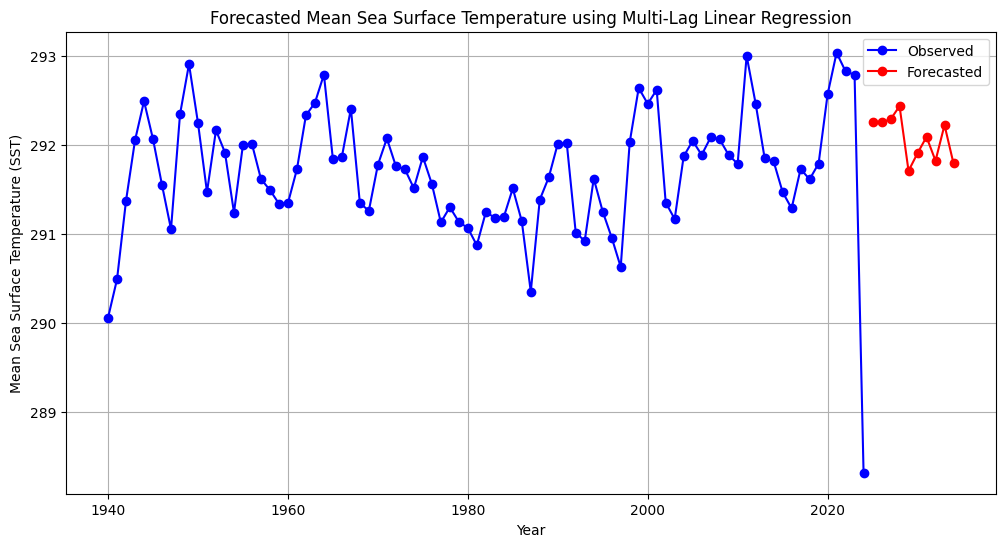

In [20]:
df['time'] = pd.to_datetime(df['time'])

df['Year'] = df['time'].dt.year

yearly_sst = df.groupby('Year')['sst'].mean().reset_index()

lags = 5
X = np.array([yearly_sst['sst'].shift(i).values for i in range(1, lags + 1)]).T[lags:]
y = yearly_sst['sst'].values[lags:]

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = LinearRegression()
model.fit(X_train, y_train)

forecast_steps = 10
forecast_X = X[-1].tolist()
forecast_y = []

for _ in range(forecast_steps):
    next_forecast = model.predict([forecast_X[-lags:]])[0]
    forecast_y.append(next_forecast)
    forecast_X.append(next_forecast)

forecast_years = np.arange(yearly_sst['Year'].max() + 1, yearly_sst['Year'].max() + 1 + forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(yearly_sst['Year'], yearly_sst['sst'], marker='o', linestyle='-', color='b', label='Observed')
plt.plot(forecast_years, forecast_y, marker='o', linestyle='-', color='r', label='Forecasted')
plt.xlabel('Year')
plt.ylabel('Mean Sea Surface Temperature (SST)')
plt.title('Forecasted Mean Sea Surface Temperature using Multi-Lag Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

 the forecast indicates that the mean SST in the North Pacific is expected to remain relatively stable with minor fluctuations over the next decade

## Conclusion


The analysis of sea surface temperature (SST) data from the North Pacific reveals significant temporal patterns, including short-term seasonal fluctuations and long-term decadal variations. Spectral analysis using Welch's method identified dominant frequencies, highlighting significant recurring patterns in the SST data. The linear regression analysis showed a gradual warming trend, with an estimated rate of 0.0040°C per year, indicating a slow but steady increase in SST over time. Forecasting with a multi-lag linear regression model suggests that the mean SST will remain relatively stable with minor fluctuations over the next decade.